In [1]:
!gdown --id 1pc9KR0mGJtgsZDpSmlcIa-Zau_Qk3yQk
!unzip bdd100k.zip
!gdown --id 1lgSGH_ifIzTSn9aeeQ1f0wYA42ctR9hB
!unzip bdd100k_drivable_maps.zip
!rm -rf "/content/bdd100k/images/100k/test"
!mv /content/bdd100k/images/100k/train/*.jpg /content/bdd100k/images/100k/train/trainA
!mv /content/bdd100k/images/100k/train/testA/*.jpg /content/bdd100k/images/100k/train/trainA
!mv /content/bdd100k/images/100k/train/testB/*.jpg /content/bdd100k/images/100k/train/trainA
!mv /content/bdd100k/images/100k/train/trainB/*.jpg /content/bdd100k/images/100k/train/trainA

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: bdd100k/drivable_maps/labels/val/be6feca9-888ffd4c_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be724abb-9a2a625c_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be731030-7593da2a_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be731030-82d58159_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be731030-c29affd6_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be73806a-cd8633af_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be769e9f-abea5fd9_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be769e9f-ed37df2b_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be76ea62-78b2c8f8_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be776742-fe6599b2_drivable_id.png  
 extracting: bdd100k/drivable_maps/labels/val/be777044-7db298a4_drivable_id.png  
 extracting: bdd100k/drivable_

In [2]:
!pip install segmentation_models_pytorch
!pip install catalyst

     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 245kB 31.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=b09efa5904706ebad9c6e525d137ecfae832631895875fa9cb9c5736ff833d57
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=8900bf55b90caf6fe97c94e0f5f14f350bcd51cdb57e410e4aa6db46be007e93
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch
     |████████████████████████████████| 491kB 19.2MB/s 
     |████████████████████████████████| 317kB 55.5MB/s 


In [3]:
import collections
import os
from pathlib import Path

import torchvision.transforms.functional as TF
import albumentations as albu
import catalyst
import matplotlib.pyplot as plt
import numpy as np
import random
import segmentation_models_pytorch as smp
import torch
from albumentations.pytorch import ToTensor
from catalyst.contrib.nn import DiceLoss
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split
from torch import optim
from torchvision import datasets, transforms, utils 
from torch.utils.data import Dataset, DataLoader
from typing import List

In [4]:
torch.manual_seed(42) 
np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
IMAGE_DIR = Path("/content/bdd100k/images/100k")
MASK_DIR = Path("bdd100k/drivable_maps/color_labels")

MEAN_FOR_NORMALIZE = np.array([0.485, 0.456, 0.406])
STD_FOR_NORMALIZE = np.array([0.229, 0.224, 0.225])

In [6]:
path_image_files = sorted(list(IMAGE_DIR.rglob('*/*.jpg')))
path_mask_files = sorted(list(MASK_DIR.rglob('*/*.png')))

In [7]:
del path_image_files[69888:70000]
del path_mask_files[69888:70000]
del path_image_files[-17:]
del path_mask_files[-17:]

In [8]:
def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")
    
def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None: ##упростить
    image_path = images[index]
    name = image_path.name

    image = imread(image_path)
    mask = imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

def tensor_imshow(img, renormalize = False, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    img = img.numpy().transpose((1, 2, 0))
    if (renormalize == True):
        img = STD_FOR_NORMALIZE * img + MEAN_FOR_NORMALIZE
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

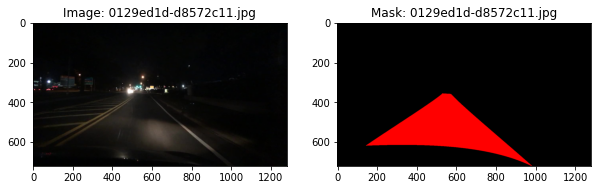

In [9]:
show_random(path_image_files, path_mask_files)

In [10]:
class BDD100kDataset(Dataset):
    
    def __init__(self, path_image_files: List[Path], path_mask_files: List[Path], transform=None) -> None:
        super().__init__()
        self._path_image_files = path_image_files
        self._path_mask_files = path_mask_files
        self._transform = transform
                      
    def __len__(self) -> int:
        return len(self._path_image_files)
          
    def _load_image(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index) -> dict:
    
        path_image_files = self._path_image_files
        path_mask_files = self._path_mask_files
          
        image_files = np.array(self._load_image(self._path_image_files[index]))
        mask_files = np.array(self._load_image(self._path_mask_files[index]))
     
        sample = {'image': image_files, 'mask': mask_files}
        
        if self._transform is not None:
            sample = self._transform(**sample)
        
        sample["mask"] = sample["mask"].squeeze(0).permute(2, 0, 1)
         
        #replace black background with green    
        sample["mask"][1] = -(sample["mask"][0] + sample["mask"][2] - 1)   
       
        return sample

## Augmentations

In [21]:
train_transforms = albu.Compose([
                                  albu.Flip(),
                                  albu.Resize(256, 256, p=1),
                                  albu.Cutout(),
                                  albu.RandomBrightnessContrast(
                                      brightness_limit=0.2, contrast_limit=0.2, p=0.3
                                  ),
                                  albu.GridDistortion(p=0.3),
                                  albu.HueSaturationValue(p=0.3),
                                  albu.Normalize(),
                                  ToTensor()
                                ])

valid_transforms = albu.Compose([
                                  albu.Resize(256, 256, p=1),
                                  albu.Normalize(),
                                  ToTensor()
                                ])


show_transforms = albu.Compose([  
                                  albu.Flip(),
                                  albu.Resize(640, 640, p=1),
                                  albu.Cutout(),
                                  albu.RandomBrightnessContrast(
                                      brightness_limit=0.2, contrast_limit=0.2, p=0.3
                                  ),
                                  albu.GridDistortion(p=0.3),
                                  albu.HueSaturationValue(p=0.3),
                                ])

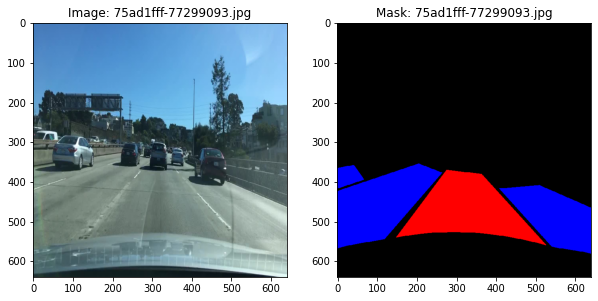

In [22]:
show_random(path_image_files, path_mask_files, transforms=show_transforms)

## Get Loaders

In [23]:
path_train_image_files, path_valid_image_files, path_train_mask_files, path_valid_mask_files = \
          train_test_split(path_image_files, path_mask_files, test_size=0.2, random_state=42)
path_valid_image_files, path_test_image_files, path_valid_mask_files, path_test_mask_files = \
          train_test_split(path_valid_image_files, path_valid_mask_files, test_size=0.5, random_state=42)

print("image_files =", len(path_image_files), "train =", len(path_train_image_files), \
     "valid =", len(path_valid_image_files), "test =", len(path_test_image_files)) 
print("mask_files =", len(path_mask_files), "train =", len(path_train_mask_files), \
      "valid =", len(path_valid_mask_files), "test =", len(path_test_mask_files))

image_files = 79871 train = 63896 valid = 7987 test = 7988
mask_files = 79871 train = 63896 valid = 7987 test = 7988


In [24]:
train_dataset = BDD100kDataset(path_train_image_files, path_train_mask_files, train_transforms)
valid_dataset = BDD100kDataset(path_valid_image_files, path_valid_mask_files, valid_transforms)
test_dataset = BDD100kDataset(path_test_image_files, path_test_mask_files, valid_transforms)

In [25]:
train_loader = DataLoader(
      train_dataset,
      batch_size=6,
      shuffle=True,
    )

valid_loader = DataLoader(
      valid_dataset,
      batch_size=6,
      shuffle=False,
    )

loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = valid_loader

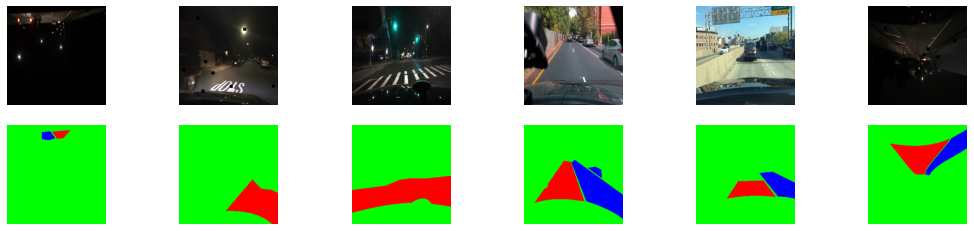

In [26]:
batch = next(iter(loaders["train"]))
plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    tensor_imshow(batch["image"][i], renormalize = True)
    plt.subplot(2, 6, i+7)
    plt.axis("off")
    tensor_imshow(batch["mask"][i])
plt.show();

## Training

In [27]:
def IoU(preds, targets, eps:float=1e-8):
   
    num_classes = preds.shape[1]
    preds = preds.max(dim = 1).indices
    targets = targets.max(dim = 1).indices
    
    iou = 0
    
    for label in range(num_classes):
        intersection = ((preds == label) & (targets == label)).sum()
        union = ((preds == label) | (targets == label)).sum()
        iou += intersection / (union + eps)
    iou /= num_classes
    return iou

In [28]:
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=3).to(device)

In [29]:
criterion = DiceLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[9], gamma=0.3
)

num_epochs = 10

In [30]:
train_loss_history = []
valid_loss_history = []
iou_train_history = []
iou_valid__history = []

for epoch in range(num_epochs): 
    
    epoch_train_loss_history = []
    epoch_valid_loss_history = []
    epoch_iou_train_history = []
    epoch_iou_valid_history = []

    train_loss = 0.0
    valid_loss = 0.0
    train_iou = 0.0
    valid_iou = 0.0

    model.train()
    for i, data in enumerate(loaders["train"]):
        
        
        inputs = data["image"].to(device)
        labels = data["mask"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_iou += IoU(outputs, labels).item()

        if (i+1) % 500 == 0:    
            print('==>epoch %d(train)   [%d/%d]   loss:%.3f,  IoU:%.3f' %
                  (epoch + 1, i + 1, len(loaders["train"]), train_loss/500, train_iou/500))
            epoch_train_loss_history.append(train_loss)
            epoch_iou_train_history.append(train_iou)
            train_loss = 0.0
            train_iou = 0.0

    model.eval()
    for i, data in enumerate(loaders["valid"]):
  
        
        inputs = data["image"].to(device)
        labels = data["mask"].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        valid_iou += IoU(outputs, labels).item()

        if (i+1) % 500 == 0:
                
            print('==>epoch %d(valid)   [%d/%d]   loss:%.3f,  IoU:%.3f' %
                  (epoch + 1, i + 1, len(loaders["valid"]), valid_loss/500, valid_iou/500))
            epoch_valid_loss_history.append(valid_loss)
            epoch_iou_valid_history.append(valid_iou)
            valid_loss = 0.0
            valid_iou = 0.0

    epoch_train_loss_history.append(sum(epoch_train_loss_history)/len(epoch_train_loss_history))
    epoch_valid_loss_history.append(sum(epoch_valid_loss_history)/len(epoch_valid_loss_history))
    epoch_iou_train_history.append(sum(epoch_iou_train_history)/len(epoch_iou_train_history))
    epoch_iou_valid_history.append(sum(epoch_iou_valid_history)/len(epoch_iou_valid_history))

    torch.save(model.state_dict(), f"model_resnet18_256.pth")

print('Finished Training')

==>epoch 1(train)   [500/10650]   loss:0.396,  IoU:0.521
==>epoch 1(train)   [1000/10650]   loss:0.268,  IoU:0.624
==>epoch 1(train)   [1500/10650]   loss:0.243,  IoU:0.650
==>epoch 1(train)   [2000/10650]   loss:0.238,  IoU:0.654
==>epoch 1(train)   [2500/10650]   loss:0.216,  IoU:0.678
==>epoch 1(train)   [3000/10650]   loss:0.223,  IoU:0.673
==>epoch 1(train)   [3500/10650]   loss:0.219,  IoU:0.677
==>epoch 1(train)   [4000/10650]   loss:0.218,  IoU:0.679
==>epoch 1(train)   [4500/10650]   loss:0.221,  IoU:0.676
==>epoch 1(train)   [5000/10650]   loss:0.209,  IoU:0.689
==>epoch 1(train)   [5500/10650]   loss:0.203,  IoU:0.695
==>epoch 1(train)   [6000/10650]   loss:0.204,  IoU:0.696
==>epoch 1(train)   [6500/10650]   loss:0.193,  IoU:0.708
==>epoch 1(train)   [7000/10650]   loss:0.202,  IoU:0.699
==>epoch 1(train)   [7500/10650]   loss:0.205,  IoU:0.696
==>epoch 1(train)   [8000/10650]   loss:0.203,  IoU:0.698
==>epoch 1(train)   [8500/10650]   loss:0.202,  IoU:0.699
==>epoch 1(trai

KeyboardInterrupt: ignored

## Test

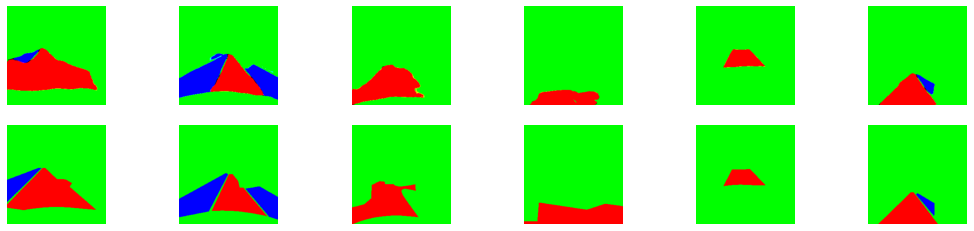

In [37]:
batch = next(iter(loaders["valid"]))
output = model(batch["image"].to(device))
plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    tensor_imshow(output[i].to("cpu").detach(), renormalize = True)
    plt.subplot(2, 6, i+7)
    plt.axis("off")
    tensor_imshow(batch["mask"][i])
plt.show();